# Basic models
## Loading data

In [362]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
%run proj1_helpers.py
%run implementations.py

In [364]:
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
tx = copy.deepcopy(tX)

## Cleaning data

In [365]:
tx = np.where(tx==-999, np.nan, tx) # replace -999 value with nan

In [366]:
col_mean = np.nanmean(tx, axis=0)
inds_nan = np.where(np.isnan(tx))
tx[inds_nan] = np.take(col_mean, inds_nan[1])

In [200]:
#CELL NOT USED
tx_stand,_,_ = standardize(tx)

In [201]:
#CELL NOT USED
tx = np.insert(tx, 0, 1, axis=1)
tx_stand = np.insert(tx_stand, 0, 1, axis=1)

## Split data

In [255]:
#CELL NOT USED
ratio_train_test = 0.8
x_train, y_train, x_test, y_test = split_data(tx_stand, y, ratio_train_test, seed=1)
x_train_ns, y_train_ns, x_test_ns, y_test_ns = split_data(tx, y, ratio_train_test, seed=1)

In [295]:
##CELL NOT USED
ratio_train_test = 0.8
x_train, y_train, x_test, y_test = split_data(tx, y, ratio_train_test, seed=1234)
x_train_ns, y_train_ns, x_test_ns, y_test_ns = split_data(tx, y, ratio_train_test, seed=1234)

In [296]:
##CELL NOT USED
x_train,_,_ = standardize(copy.deepcopy(x_train))
x_train = np.insert(x_train, 0, 1, axis=1)
x_test,_,_ = standardize(copy.deepcopy(x_test))
x_test = np.insert(x_test, 0, 1, axis=1)
x_train_ns = np.insert(x_train_ns, 0, 1, axis=1)
x_test_ns = np.insert(x_test_ns, 0, 1, axis=1)

## Cross-validation

In [367]:
#Divide the data into 5 parts
num_folds = 5
shuffled_indices = np.arange(tx.shape[0])
np.random.seed(1)
np.random.shuffle(shuffled_indices)
folds_indices = np.array_split(shuffled_indices, num_folds)
x_folds = []
y_folds = []
for fold in folds_indices:
    x_folds.append(tx[fold])
    y_folds.append(y[fold])

In [369]:
# Put those parts together to make 5 train/test splits
x_train = []
x_test = []
x_train_ns = []
x_test_ns = []
y_train = []
y_test = []
for i in range(num_folds):
    x_test_ns.append(x_folds[i])
    y_test.append(y_folds[i])
    indices = [j for j in range(num_folds) if j != i]
    x_train_ns.append(np.concatenate([x_folds[j] for j in indices]))
    y_train.append(np.concatenate([y_folds[j] for j in indices]))
    #standardize
    x_train.append(standardize(copy.deepcopy(x_train_ns[i]))[0])
    x_test.append(standardize(copy.deepcopy(x_test_ns[i]))[0])
    #insert column of ones
    x_train_ns[i] = np.insert(x_train_ns[i], 0, 1, axis=1)
    x_test_ns[i] = np.insert(x_test_ns[i], 0, 1, axis=1)
    x_train[i] = np.insert(x_train[i], 0, 1, axis=1)
    x_test[i] = np.insert(x_test[i], 0, 1, axis=1)

## Linear Regression with Gradient Descent

In [437]:
cat_accuracies_train = []
cat_accuracies_test = []
f1_scores_train = []
f1_scores_test = []
for i in range(num_folds):
    weights_LSGD1 = least_squares_GD(y_train[i], x_train[i], np.zeros(31), 100, 0.000001)[0]
    cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights_LSGD1, x_train[i]))
    cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights_LSGD1, x_test[i]))
    cat_accuracies_train.append(cat_accuracy_train)
    cat_accuracies_test.append(cat_accuracy_test)
    f1_scores_train.append(f1_score_train)
    f1_scores_test.append(f1_score_test)

print("Categorical accuracy train : ",cat_accuracies_train," || f1_score train: ",f1_scores_train)
print("Categorical accuracy test : ",cat_accuracies_test," || f1_score test: ",f1_scores_test)
print("Categorical accuracy train mean: ",np.mean(cat_accuracies_train), " stdev: ", np.std(cat_accuracies_train))
print("Categorical accuracy test mean: ",np.mean(cat_accuracies_test), " stdev: ", np.std(cat_accuracies_test))

Categorical accuracy train :  [0.70101, 0.70141, 0.70037, 0.70119, 0.70122]  || f1_score train:  [0.30688547350064127, 0.3068926400623064, 0.30511347265300587, 0.3058169774080694, 0.3063047804547572]
Categorical accuracy test :  [0.70098, 0.69896, 0.70346, 0.70072, 0.7006]  || f1_score test:  [0.3048548955790616, 0.3047974232920834, 0.30732252276651206, 0.3068926400623064, 0.306577253945675]
Categorical accuracy train mean:  0.7010400000000001  stdev:  0.00035821781083578065
Categorical accuracy test mean:  0.700944  stdev:  0.0014447366542037871


In [438]:
def least_squares_GD_cv(y, x, test_y, test_x, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights_LSGD1 = least_squares_GD(y[i], x[i], w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y[i], predict_labels(weights_LSGD1, x[i]))
        cat_accuracy_test, f1_score_test = metrics(test_y[i], predict_labels(weights_LSGD1, test_x[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [439]:
gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean1 = []
accuracies_test_mean1 = []
accuracies_train_std1 = []
accuracies_test_std1 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_GD_cv(y_train, x_train, y_test, x_test, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean1.append(np.mean(cat_accuracies_train))
    accuracies_test_mean1.append(np.mean(cat_accuracies_test))
    accuracies_train_std1.append(np.std(cat_accuracies_train))
    accuracies_test_std1.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean1)
print(accuracies_test_mean1)
print(accuracies_train_std1)
print(accuracies_test_std1)

Gamma: 1e-06 || Categorical accuracy train : ( 0.7010400000000001 ,  0.00035821781083578065 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.700944 ,  0.0014447366542037871 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.70108 ,  0.00036297382825763023 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.7009559999999999 ,  0.0014701510126514169 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.7015100000000001 ,  0.00044707941129065265 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.7015 ,  0.0015816447135814059 )
Gamma: 0.001 || Categorical accuracy train : ( 0.705468 ,  0.00039593686365378835 )
Gamma: 0.001 || Categorical accuracy test : ( 0.705444 ,  0.0012901100728232213 )
Gamma: 0.01 || Categorical accuracy train : ( 0.7248060000000001 ,  0.000568545512690078 )
Gamma: 0.01 || Categorical accuracy test : ( 0.7247679999999999 ,  0.0022847179256967293 )
Gamma: 0.05 || Categorical accuracy train : ( 0.7369410000000001 ,  0.0006012769744468879 )
Gamma: 0.05 || Categorical accura

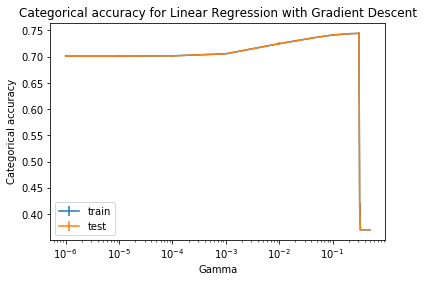

In [440]:
plt.errorbar(gammas[:], accuracies_train_mean1, yerr=accuracies_train_std1, label="train")
plt.errorbar(gammas[:], accuracies_test_mean1, yerr=accuracies_test_std1, label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

In [423]:
np.array(accuracies_train_mean1) - np.array(accuracies_test_mean1)

array([ 9.60e-05,  1.24e-04,  1.00e-05,  2.40e-05,  3.80e-05,  1.29e-04,
       -2.00e-06, -9.20e-05, -5.50e-05, -9.70e-05,  1.68e-04, -4.90e-05,
       -2.90e-05, -2.80e-05, -2.80e-05])

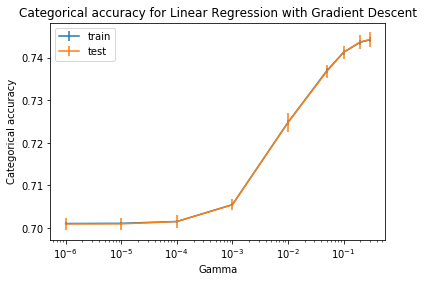

In [441]:
plt.errorbar(gammas[:9], accuracies_train_mean1[:9], yerr=accuracies_train_std1[:9], label="train")
plt.errorbar(gammas[:9], accuracies_test_mean1[:9], yerr=accuracies_test_std1[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

### Least Squares GD with non-standardized data

In [428]:
gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean2 = []
accuracies_test_mean2 = []
accuracies_train_std2 = []
accuracies_test_std2 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_GD_cv(y_train, x_train_ns, y_test, x_test_ns, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean2.append(np.mean(cat_accuracies_train))
    accuracies_test_mean2.append(np.mean(cat_accuracies_test))
    accuracies_train_std2.append(np.std(cat_accuracies_train))
    accuracies_test_std2.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean2)
print(accuracies_test_mean2)
print(accuracies_train_std2)
print(accuracies_test_std2)

Gamma: 1e-07 || Categorical accuracy train : ( 0.657332 ,  0.0004281775332733195 )
Gamma: 1e-07 || Categorical accuracy test : ( 0.657332 ,  0.001712710133093164 )
Gamma: 1e-06 || Categorical accuracy train : ( 0.6655960000000001 ,  0.0002944554295644445 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.665576 ,  0.0016871941204259547 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.001 || Categorical accuracy train : ( 0.34266800000000003 ,  0.00042817753327328243 )
Gamma: 0.001 || Categorical accuracy test : ( 0.34266800000000003 ,  0.0017127101330931612 )
Gamma: 0.01 || Categorical accuracy train : ( 0.657332 ,  0.0004281775332733195 )
Gamma: 0.01 |

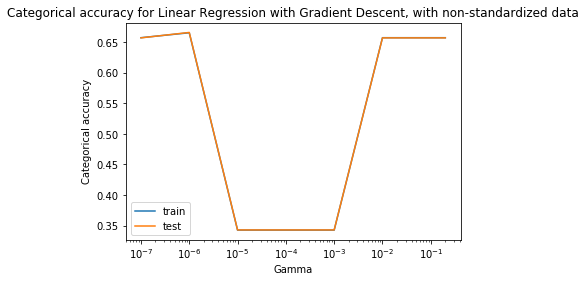

In [278]:
plt.plot(gammas[:9], accuracies_train_2[:9], label="train")
plt.plot(gammas[:9], accuracies_test_2[:9], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent, with non-standardized data")
plt.legend()
plt.show()

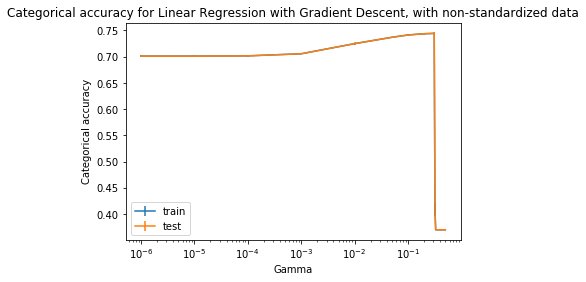

In [426]:
plt.errorbar(gammas[:], accuracies_train_mean2[:], yerr=accuracies_train_std2[:], label="train")
plt.errorbar(gammas[:], accuracies_test_mean2[:], yerr=accuracies_test_std2[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Gradient Descent, with non-standardized data")
plt.legend()
plt.show()

## Linear Regression with Stochastic Gradient Descent

In [405]:
def least_squares_SGD_cv(y_train, x_train, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = least_squares_SGD(y_train[i], x_train[i], w_i, max_iter, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [406]:
gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
accuracies_train_mean3 = []
accuracies_test_mean3 = []
accuracies_train_std3 = []
accuracies_test_std3 = []
for gamma in gammas:
    cat_accuracies_train, cat_accuracies_test = least_squares_SGD_cv(y_train, x_train, np.zeros(31), 100, gamma)
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean3.append(np.mean(cat_accuracies_train))
    accuracies_test_mean3.append(np.mean(cat_accuracies_test))
    accuracies_train_std3.append(np.std(cat_accuracies_train))
    accuracies_test_std3.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean3)
print(accuracies_test_mean3)
print(accuracies_train_std3)
print(accuracies_test_std3)

Gamma: 1e-07 || Categorical accuracy train : ( 0.6761790000000001 ,  0.010638267434126646 )
Gamma: 1e-07 || Categorical accuracy test : ( 0.6770919999999999 ,  0.011886150596387392 )
Gamma: 1e-06 || Categorical accuracy train : ( 0.684217 ,  0.008137389384808853 )
Gamma: 1e-06 || Categorical accuracy test : ( 0.6845000000000001 ,  0.008879486471637872 )
Gamma: 1e-05 || Categorical accuracy train : ( 0.6783429999999999 ,  0.005997202347761817 )
Gamma: 1e-05 || Categorical accuracy test : ( 0.678476 ,  0.0060583879043851025 )
Gamma: 0.0001 || Categorical accuracy train : ( 0.685115 ,  0.01603992736891287 )
Gamma: 0.0001 || Categorical accuracy test : ( 0.684556 ,  0.015705292865782528 )
Gamma: 0.001 || Categorical accuracy train : ( 0.693164 ,  0.010848523125292197 )
Gamma: 0.001 || Categorical accuracy test : ( 0.6928839999999999 ,  0.010629531692412417 )
Gamma: 0.01 || Categorical accuracy train : ( 0.6835289999999999 ,  0.020502015852105874 )
Gamma: 0.01 || Categorical accuracy test :

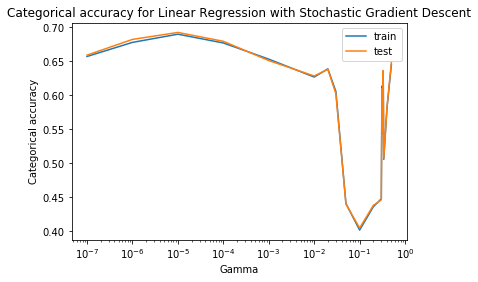

In [407]:
plt.plot(gammas[:], accuracies_train_3[:], label="train")
plt.plot(gammas[:], accuracies_test_3[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Stochastic Gradient Descent")
plt.legend()
plt.show()

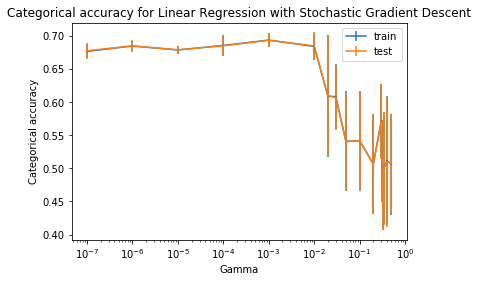

In [408]:
plt.errorbar(gammas[:], accuracies_train_mean3[:], yerr=accuracies_train_std3[:], label="train")
plt.errorbar(gammas[:], accuracies_test_mean3[:], yerr=accuracies_test_std3[:], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Linear Regression with Stochastic Gradient Descent")
plt.legend()
plt.show()

## Least Squares

In [424]:
def least_squares_cv(y_train, x_train, y_test, x_test):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = least_squares(y_train[i], x_train[i])[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [425]:
cat_accuracies_train4, cat_accuracies_test4 = least_squares_cv(y_train, x_train, y_test, x_test)

print("Categorical accuracy train : (",np.mean(cat_accuracies_train4),", ", np.std(cat_accuracies_train4),")")
print("Categorical accuracy test : (",np.mean(cat_accuracies_test4),", ", np.std(cat_accuracies_test4),")")

Categorical accuracy train : ( 0.744493 ,  0.0006400749956060015 )
Categorical accuracy test : ( 0.706348 ,  0.021547419706312843 )


## Ridge regression

In [413]:
def ridge_regression_cv(y_train, x_train, lambda_):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = ridge_regression(y_train[i], x_train[i], lambda_)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [415]:
lambdas =  np.logspace(-6, 12, 40)
accuracies_train_mean5 = []
accuracies_test_mean5 = []
accuracies_train_std5 = []
accuracies_test_std5 = []
for lambda_ in lambdas:
    cat_accuracies_train, cat_accuracies_test = ridge_regression_cv(y_train, x_train, lambda_)
    
    print("Lambda: " + str(lambda_) + " || Categorical accuracy train : (",np.mean(cat_accuracies_train),", ", np.std(cat_accuracies_train),")")
    print("Lambda: " + str(lambda_) + " || Categorical accuracy test : (",np.mean(cat_accuracies_test),", ", np.std(cat_accuracies_test),")")
    accuracies_train_mean5.append(np.mean(cat_accuracies_train))
    accuracies_test_mean5.append(np.mean(cat_accuracies_test))
    accuracies_train_std5.append(np.std(cat_accuracies_train))
    accuracies_test_std5.append(np.std(cat_accuracies_test))
    
print(accuracies_train_mean5)
print(accuracies_test_mean5)
print(accuracies_train_std5)
print(accuracies_test_std5)

Lambda: 1e-06 || Categorical accuracy train : ( 0.7444919999999999 ,  0.0006442251159338472 )
Lambda: 1e-06 || Categorical accuracy test : ( 0.706584 ,  0.021464603047808752 )
Lambda: 2.894266124716752e-06 || Categorical accuracy train : ( 0.744494 ,  0.0006440139750036307 )
Lambda: 2.894266124716752e-06 || Categorical accuracy test : ( 0.706924 ,  0.021380901384179286 )
Lambda: 8.376776400682924e-06 || Categorical accuracy train : ( 0.744492 ,  0.0006401609172700525 )
Lambda: 8.376776400682924e-06 || Categorical accuracy test : ( 0.708172 ,  0.021165748179547077 )
Lambda: 2.424462017082331e-05 || Categorical accuracy train : ( 0.744499 ,  0.0006373021261536687 )
Lambda: 2.424462017082331e-05 || Categorical accuracy test : ( 0.710884 ,  0.020403064083612532 )
Lambda: 7.017038286703837e-05 || Categorical accuracy train : ( 0.744494 ,  0.0006333908745790631 )
Lambda: 7.017038286703837e-05 || Categorical accuracy test : ( 0.71778 ,  0.018846287698111794 )
Lambda: 0.00020309176209047368 ||

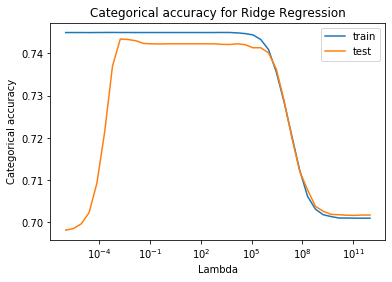

In [287]:
plt.plot(lambdas[:], accuracies_train_4[:], label="train")
plt.plot(lambdas[:], accuracies_test_4[:], label="test")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Ridge Regression")
plt.legend()
plt.show()

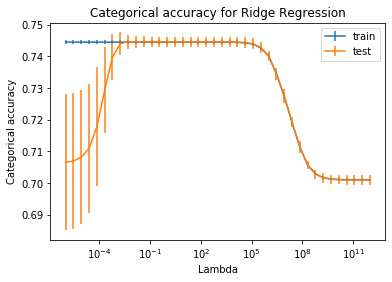

In [416]:
plt.errorbar(lambdas[:], accuracies_train_mean5[:], yerr=accuracies_train_std5[:], label="train")
plt.errorbar(lambdas[:], accuracies_test_mean5[:], yerr=accuracies_test_std5[:], label="test")
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Ridge Regression")
plt.legend()
plt.show()

In [288]:
print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_4)], ", train accuracy: ", accuracies_train_4[np.argmax(accuracies_test_4)], ", test accuracy: ", accuracies_test_4[np.argmax(accuracies_test_4)])

Best performance: lambda  0.0017012542798525892 , train accuracy:  0.74494034938219 , test accuracy:  0.7433976020738821


In [417]:
print("Best performance: lambda ", lambdas[np.argmax(accuracies_test_mean5)], ", train accuracy: ", accuracies_train_mean5[np.argmax(accuracies_test_mean5)], ", test accuracy: ", accuracies_test_mean5[np.argmax(accuracies_test_mean5)], ", std: ", accuracies_test_std5[np.argmax(accuracies_test_mean5)])

Best performance: lambda  0.11937766417144383 , train accuracy:  0.744487 , test accuracy:  0.7446280000000001 , std:  0.0016138203121785107


## Logistic regression

In [418]:
def logsitic_regression_cv(y_train, x_train, w_i, max_iter, gamma):
    cat_accuracies_train = []
    cat_accuracies_test = []
    f1_scores_train = []
    f1_scores_test = []
    for i in range(num_folds):
        weights = logistic_regression(y_train[i], x_train[i], w_i, max_ited, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train[i], predict_labels(weights, x_train[i]))
        cat_accuracy_test, f1_score_test = metrics(y_test[i], predict_labels(weights, x_test[i]))
        cat_accuracies_train.append(cat_accuracy_train)
        cat_accuracies_test.append(cat_accuracy_test)
        f1_scores_train.append(f1_score_train)
        f1_scores_test.append(f1_score_test)
    return cat_accuracies_train, cat_accuracies_test

In [220]:
y_train_log = np.copy(y_train)
y_train_log = np.where(y_train_log==-1, 0, y_train_log)

y_test_log = np.copy(y_test)
y_test_log = np.where(y_test_log==-1, 0, y_test_log)

gammas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4, 0.5]
weights_result_5 = []
accuracies_train_5 = []
accuracies_test_5 = []
for gamma in gammas:
    weights_LR = logistic_regression(y_train_log, x_train, np.zeros(31), 10000, gamma)[0]
    cat_accuracy_train, f1_score_train = metrics(y_train_log, predict_labels(weights_LR, x_train))
    cat_accuracy_test, f1_score_test = metrics(y_test_log, predict_labels(weights_LR, x_test))
    
    print("Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
    print("Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
    weights_result_5.append(weights_LR)
    accuracies_train_5.append(cat_accuracy_train)
    accuracies_test_5.append(cat_accuracy_test)
    
print(accuracies_train_5)
print(accuracies_test_5)

The loss for step 0 is 155989.9942229971.
The loss for step 1000 is 155986.6570715598.
The loss for step 2000 is 155982.98179237847.
The loss for step 3000 is 155980.06425238322.
The loss for step 4000 is 155976.5968732667.
The loss for step 5000 is 155973.095968284.
The loss for step 6000 is 155969.6429974646.
The loss for step 7000 is 155966.12319732865.
The loss for step 8000 is 155962.90345196048.
The loss for step 9000 is 155959.52730909263.
Gamma: 1e-07 || Categorical accuracy train :  0.7000702078686135  || f1_score train:  0.3066197633514551
Gamma: 1e-07 || Categorical accuracy test :  0.7009297106676284  || f1_score test:  0.3029107725788901
The loss for step 0 is 155989.96826378352.
The loss for step 1000 is 155956.79188752055.
The loss for step 2000 is 155923.7250396881.
The loss for step 3000 is 155889.3155319965.
The loss for step 4000 is 155858.36890505935.
The loss for step 5000 is 155824.44251516537.
The loss for step 6000 is 155791.68708996166.
The loss for step 7000 i

In [221]:
print("Best performance: gamma ", gammas[np.argmax(accuracies_test_5)], ", train accuracy: ", accuracies_train_5[np.argmax(accuracies_test_5)], ", test accuracy: ", accuracies_test_5[np.argmax(accuracies_test_5)])

Best performance: gamma  0.01 , train accuracy:  0.7480070741092932 , test accuracy:  0.7530656407790334


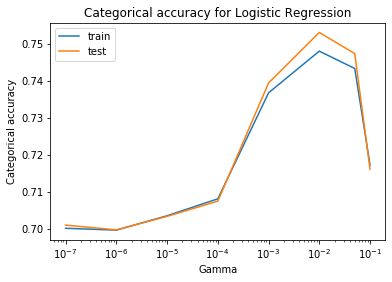

In [222]:
plt.plot(gammas[:8], accuracies_train_5[:8], label="train")
plt.plot(gammas[:8], accuracies_test_5[:8], label="test")
plt.xscale("log")
plt.xlabel("Gamma")
plt.ylabel("Categorical accuracy")
plt.title("Categorical accuracy for Logistic Regression")
plt.legend()
plt.show()

## Regularized logistic regression

In [193]:
gammas = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2]
lambdas = lambdas =  np.logspace(-4, 4, 5)
weights_result_6 = []
accuracies_train_6 = []
accuracies_test_6 = []
for lambda_ in lambdas:
    accuracy_train = []
    accuracy_test = []
    weights = []
    for gamma in gammas:
        weights_RLR = reg_logistic_regression(y_train_log, x_train, lambda_, np.zeros(31), 10000, gamma)[0]
        cat_accuracy_train, f1_score_train = metrics(y_train_log, predict_labels(weights_RLR, x_train))
        cat_accuracy_test, f1_score_test = metrics(y_test_log, predict_labels(weights_RLR, x_test))

        print("Lambda: " + str(lambda_) + " Gamma: " + str(gamma) + " || Categorical accuracy train : ",cat_accuracy_train," || f1_score train: ",f1_score_train)
        print("Lambda: " + str(lambda_) + " Gamma: " + str(gamma) + " || Categorical accuracy test : ",cat_accuracy_test," || f1_score test: ",f1_score_test)
        weights.append(weights_RLR)
        accuracy_train.append(cat_accuracy_train)
        accuracy_test.append(cat_accuracy_test)
    weights_result_6.append(weights)
    accuracies_train_6.append(accuracy_train)
    accuracies_test_6.append(accuracy_test)

print(accuracies_train_6)
print(accuracies_test_6)

IndexError: list index out of range

In [191]:
best_index = np.unravel_index(np.argmax(np.matrix(accuracies_test_6), axis=None), np.matrix(accuracies_test_6).shape)
print(np.argmax(accuracies_test_6))
print("Best performance: lambda ", lambdas[best_index[0]], ", gamma: ", gammas[best_index[1]], ", train accuracy: ", accuracies_train_6[best_index], ", test accuracy: ", accuracies_test_6[best_index])

0


TypeError: list indices must be integers or slices, not tuple

In [194]:
weights_result_6

[]

# Advanced models

## Categorical splitting

In [241]:
len(tX[np.where(tX[:,22]==3)])

22164